Code extracted from nems/scripts/demo_script_2p.py

In [1]:
%matplotlib inline
import os
import logging
import pandas as pd
import pickle
import sys
import numpy as np
import matplotlib.pyplot as plt

from nems.gui.recording_browser import browse_recording, browse_context
import nems
import nems.initializers
import nems.priors
import nems.preprocessing as preproc
import nems.plots.api as nplt
import nems.modelspec as ms
import nems.xforms as xforms
import nems.utils
import nems.uri
import nems.recording as recording
from nems.signal import RasterizedSignal
from nems.fitters.api import scipy_minimize
import nems.db as nd

log = logging.getLogger(__name__)


[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2018-12-05 154936.log


## PARAMETERS AND FILE LOCATIONS ##

In [3]:
# data file and results locations
# defined in nems/nems/configs/settings.py, which will override
# defaults in nems/nems/configs/defaults.py
results_dir = nems.get_setting('NEMS_RESULTS_DIR')
recordings_dir = nems.get_setting('NEMS_RECORDINGS_DIR')

# 2p data from Polley Lab at EPL
respfile = os.path.join(recordings_dir, 'data_nems_2p/neurons.csv')
stimfile = os.path.join(recordings_dir, 'data_nems_2p/stim_spectrogram.csv')
exptid = "POL001"
cellid = "POL001-080"
batch = 1  # define the group of data this belong to (eg, 1: A1, 2: AAF, etc)
load_command='nems.demo.loaders.load_polley_data'


Alternatively, this is a more complex model (slower but possibly more accurate):

In [4]:
modelspecname = 'dlog-wc.9x2.g-fir.2x15-lvl.1'

This one includes short-term plasticity (STP) for each spectral channel. Again, probably not helpful for such a sparse stimulus

In [5]:
modelspecname = 'dlog-wcg.18x1-stp.1-fir.1x15-lvl.1-dexp.1'

This model schema is simple and fast

In [4]:
modelspecname = 'wc.9x1.g-fir.1x15-lvl.1'

Specialized function to load 2p data (may be slow!)

In [ ]:
from nems.demo.loaders import load_polley_data
r = load_polley_data(load_command=load_command,
                respfile=respfile,
                stimfile=stimfile,
                exptid=exptid,
                cellid=cellid)
print(r.keys())
print(r['stim'].shape)

## DO THE FIT ##

Define the `xforms` script for loading, fitting, and assessing performance

In [5]:
# metadata describing the experiment that will be logged in the database if the model is saved
meta = {'cellid': cellid, 'exptid': exptid, 'batch': batch, 'modelname': modelspecname}

xfspec = []
xfspec.append(['nems.xforms.load_recording_wrapper',
               {'load_command': load_command,
                'respfile': respfile,
                'stimfile': stimfile,
                'exptid': exptid,
                'cellid': cellid}])

# reserve 10% of the data for validation
xfspec.append(['nems.xforms.split_at_time', {'valfrac': 0.1}])

xfspec.append(['nems.xforms.init_from_keywords',
               {'keywordstring': modelspecname, 'meta': meta}])

xfspec.append(['nems.xforms.fit_basic_init', {}])
xfspec.append(['nems.xforms.fit_basic', {}])
xfspec.append(['nems.xforms.predict',    {}])
# xfspec.append(['nems.xforms.add_summary_statistics',    {}])
xfspec.append(['nems.analysis.api.standard_correlation', {},
               ['est', 'val', 'modelspec', 'rec'], ['modelspec']])
xfspec.append(['nems.xforms.plot_summary',    {}])


First `xforms` command calls the loading function

In [6]:
xfspec[0]

['nems.xforms.load_recording_wrapper',
 {'load_command': 'nems.demo.loaders.load_polley_data',
  'respfile': '/auto/users/svd/projects/nems_test/recordings/data_nems_2p/neurons.csv',
  'stimfile': '/auto/users/svd/projects/nems_test/recordings/data_nems_2p/stim_spectrogram.csv',
  'exptid': 'POL001',
  'cellid': 'POL001-080'}]

Here's the command that defines the `modelspec`

In [7]:
xfspec[2]

['nems.xforms.init_from_keywords',
 {'keywordstring': 'wc.9x1.g-fir.1x15-lvl.1',
  'meta': {'cellid': 'POL001-080',
   'exptid': 'POL001',
   'batch': 1,
   'modelname': 'wc.9x1.g-fir.1x15-lvl.1'}}]

actually do the fit

[nems.xforms INFO] Evaluating: nems.xforms.load_recording_wrapper
[nems.xforms INFO] Loading cached file /auto/users/svd/projects/nems_test/recordings/POL001_6d39a8c6f579f8762d24e0e88955bb216c6b5e0f.tgz
[nems.xforms INFO] match found, extracting channel from rec
[nems.xforms INFO] Evaluating: nems.xforms.split_at_time
[nems.xforms INFO] Evaluating: nems.xforms.init_from_keywords
[nems.initializers INFO] kw: wc.9x1.g
[nems.initializers INFO] kw: fir.1x15
[nems.initializers INFO] kw: lvl.1
[nems.xforms INFO] Evaluating: nems.xforms.fit_basic_init
[nems.initializers INFO] target_module: levelshift found at modelspec[2].
[nems.fitters.fitter INFO] Starting sigma: [0.5, 0.3191538243211462, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

/home/svd/bin/miniconda3/envs/nems_test/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `ar

CHANS: 
['4.0', '5.7', '8.0', '11.3', '16.0', '22.6', '32.0', '45.3', '64.0']


[nems.xforms INFO] Done (re-)evaluating xforms.


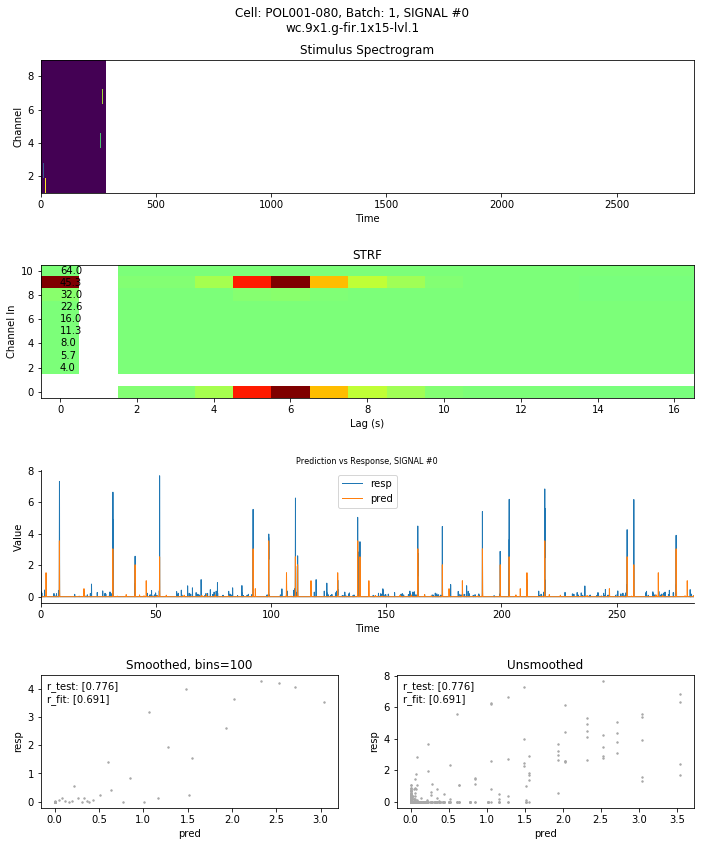

In [8]:
ctx, log_xf = xforms.evaluate(xfspec)

# shorthand for iterating through each xfspec entry:
# ctx = {}
# for xfa in xfspec:
#     ctx = xforms.evaluate_step(xfa, ctx)


## LOOK AT THE RESULTS ##

In [9]:
ctx['val'].signals

{'resp': <nems.signal.RasterizedSignal at 0x7fbb6370e080>,
 'stim': <nems.signal.RasterizedSignal at 0x7fbb6370e1d0>,
 'pred': <nems.signal.RasterizedSignal at 0x7fbb636efb00>}

In [10]:
modelspec = ctx['modelspec']
modelspec[0]['plot_fns']

['nems.plots.api.mod_output', 'nems.plots.api.weight_channels_heatmap']

In [11]:
modelspec = ctx['modelspec']
modelspec[0]['plot_fns'].append('nems.plots.api.spectrogram')
modelspec[0]['plot_fn_idx']=2

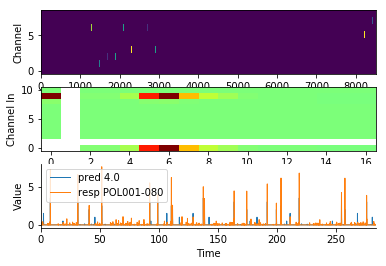

In [12]:
# testing new plotting system
modelspec[0]['plot_fn_idx']=2
fig=modelspec.quickplot(ctx['val'])


In [13]:
modelspec.meta()

{'cellid': 'POL001-080',
 'exptid': 'POL001',
 'batch': 1,
 'modelname': 'wc.9x1.g-fir.1x15-lvl.1',
 'fitter': 'fit_basic',
 'fit_time': 0.8475844860076904,
 'n_parms': 18,
 'r_test': array([0.77566994]),
 'se_test': array([0.03108066]),
 'r_floor': array([0.0380764]),
 'mse_test': array([0.66091728]),
 'se_mse_test': array([0.02945958]),
 'll_test': 0.4482404081957795,
 'r_fit': array([0.6913715]),
 'se_fit': array([0.01415284]),
 'r_ceiling': 0,
 'mse_fit': array([0.72251715]),
 'se_mse_fit': array([0.01355246]),
 'll_fit': 0.48364801153937}

## SAVE YOUR RESULTS ##

In [14]:
# save results to file
destination = os.path.join(results_dir, str(batch), xforms.get_meta(ctx)['cellid'],
                           ms.get_modelspec_longname(ctx['modelspec']))
log.info('Saving modelspec(s) to {0} ...'.format(destination))
xforms.save_analysis(destination,
                     recording=ctx['rec'],
                     modelspec=ctx['modelspec'],
                     xfspec=xfspec,
                     figures=ctx['figures'],
                     log=log_xf)

# save summary of results to a database
log.info('Saving metadata to db  ...')
modelspec = ctx['modelspec']
modelspec.meta()['modelpath'] = destination
modelspec.meta()['figurefile'] = destination + 'figure.0000.png'
nd.update_results_table(modelspec)
    

[__main__ INFO] Saving modelspec(s) to /auto/users/svd/projects/nems_test/results/1/POL001-080/POL001.wc.9x1.g_fir.1x15_lvl.1.fit_basic.2018-12-05T235130 ...
[__main__ INFO] Saving metadata to db  ...


2

## RELOAD ##

Load a model that has previously been saved. Specified uniquely by cellid/batch/modelspecname

In [2]:
# reload using:
# repeated from above
import nems.db as nd
import nems.xforms as xforms

# pick your cell/batch/model
cellid = "POL001-080"
batch = 1  # define the group of data this belong to (eg, 1: A1, 2: AAF, etc)
modelspecname = 'wc.9x1.g-fir.1x15-lvl.1'

# find the results in the database
d=nd.get_results_file(batch=batch, cellids=[cellid], modelnames=[modelspecname])
d.loc[0]
filepath = d['modelpath'][0] + '/'

# load and display results
xfspec, ctx = xforms.load_analysis(filepath, eval_model=True)


[nems.xforms INFO] Loading modelspec from /auto/users/svd/projects/nems_test/results/1/POL001-080/unknown_recording.wc.9x1.g_fir.1x15_lvl.1.fit_basic.2018-12-05T210456/...
[nems.xforms INFO] Evaluating: nems.xforms.load_recording_wrapper
[nems.xforms INFO] Loading cached file /auto/users/svd/projects/nems_test/recordings/POL001_6d39a8c6f579f8762d24e0e88955bb216c6b5e0f.tgz
[nems.xforms INFO] match found, extracting channel from rec
[nems.xforms INFO] Evaluating: nems.xforms.split_at_time
[nems.xforms INFO] Evaluating: nems.xforms.init_from_keywords
[nems.xforms INFO] Evaluating: nems.xforms.fit_basic_init
[nems.xforms INFO] Evaluating: nems.xforms.fit_basic
[nems.xforms INFO] Evaluating: nems.xforms.predict
/home/svd/bin/miniconda3/envs/nems_test/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array

Query the database for all models fit for a single cell/batch:

In [20]:
import nems.db as nd
import nems.xforms as xforms

# pick your cell/batch/model
cellid = "POL001-080"
batch = 1  # define the group of data this belong to (eg, 1: A1, 2: AAF, etc)

# find the results in the database
d=nd.get_results_file(batch=batch, cellids=[cellid])
d[['modelname','r_test','figurefile']]

,modelname,r_test,figurefile
0,dlog-wc.9x2.g-fir.2x15-lvl.1,0.774614,/auto/users/svd/projects/nems_test/results/1/P...
1,wc.9x1.g-fir.1x15-lvl.1,0.775670,/auto/users/svd/projects/nems_test/results/1/P...


In [6]:
modelspec=ctx['modelspec']
modelspec.meta()

{'cellid': 'POL001-080',
 'batch': 1,
 'modelname': 'wc.9x1.g-fir.1x15-lvl.1',
 'fitter': 'fit_basic',
 'fit_time': 0.44434118270874023,
 'n_parms': 18,
 'r_test': array([0.77566994]),
 'se_test': array([0.03108066]),
 'r_floor': array([0.04457513]),
 'mse_test': array([0.66091728]),
 'se_mse_test': array([0.02945958]),
 'll_test': 0.4482404081957795,
 'r_fit': array([0.6913715]),
 'se_fit': array([0.01415284]),
 'r_ceiling': 0,
 'mse_fit': array([0.72251715]),
 'se_mse_fit': array([0.01355246]),
 'll_fit': 0.48364801153937,
 'xfspec': '/auto/users/svd/projects/nems_test/results/1/POL001-080/unknown_recording.wc.9x1.g_fir.1x15_lvl.1.fit_basic.2018-12-05T210456/xfspec.json'}